# CS4248 Project Group 23

In [ ]:
# If you wish to run this on Google Colab, mount the Google drive by running this cell or click the `files` icon on the left navbar
# and click mount Google Drive (it takes some time to load)
from google.colab import drive
drive.mount('/content/drive')

%cd "/content/drive/My Drive/CS4248_BERT.ipynb"
!cd "/content/drive/My Drive/CS4248_BERT.ipynb"

In [ ]:
!pip show transformers

In [ ]:
!pip install --upgrade transformers #upgrade transformers to 4.39.x, don't use 4.38.x

In [1]:
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score
import numpy as np

In [2]:
from sklearn.utils import resample

train = pd.read_csv("/kaggle/input/raw-data/raw_data/raw_data/fulltrain.csv", names=['Verdict', 'Text'])

minority_class = train[train['Verdict'] == 4]
majority_class = train[train['Verdict'] != 4]

# Downsample the majority class
majority_downsampled = resample(majority_class, replace=False, n_samples=len(minority_class), random_state=42)

# Combine the downsampled majority class with the minority class
balanced_data = pd.concat([majority_downsampled, minority_class])

In [3]:
from transformers import BertTokenizer

seq_len = 512
num_samples = len(balanced_data)
Xids = np.zeros((num_samples, seq_len))
Xmask = np.zeros((num_samples, seq_len))    #attention mask


In [ ]:
print(len(balanced_data[balanced_data['Verdict'] ==4]))
print(len(balanced_data[balanced_data['Verdict'] ==1]) + len(balanced_data[balanced_data['Verdict'] ==2])+ len(balanced_data[balanced_data['Verdict'] ==3]))
print(len(balanced_data))

In [ ]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')


for i, text in enumerate(balanced_data['Text']):
    tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_tensors='tf')
    Xids[i, :] = tokens['input_ids']
    Xmask[i, :] = tokens['attention_mask']

In [ ]:
np.savetxt('Xids_2classes_downsampledv2.txt', Xids)
np.savetxt('Xmask_2classes_downsampledv2.txt', Xmask)

In [4]:
#to load previous tokens
Xids = np.loadtxt("/kaggle/input/raw-data/Xids_2classes_downsampledv2.txt")
Xmask = np.loadtxt("/kaggle/input/raw-data/Xmask_2classes_downsampledv2.txt")

In [19]:
Xids.shape

(19990, 512)

In [5]:
y_train = balanced_data['Verdict'].values.copy()
y_train[y_train != 4] = 0
y_train[y_train == 4] = 1
y_labels = np.zeros((num_samples, y_train.max()+1))
y_labels[np.arange(num_samples), y_train] = 1   #one-hot encoding of the labels

In [ ]:
print(y_labels)
print(y_labels.shape)

In [6]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, y_labels))
dataset.take(1)

2024-04-15 06:29:25.588273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 06:29:25.588379: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 06:29:25.726380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [7]:
def map_func(input_ids, masks, labels):
    return {'input_ids': input_ids, 'attention_mask': masks}, labels    #create a tuple of dictionaries

dataset = dataset.map(map_func)
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(2,), dtype=tf.float64, name=None))>

In [8]:
batch_size = 16
dataset = dataset.shuffle(num_samples).batch(batch_size, drop_remainder=True) #shuffle the data, then batch it and drop remainder if any
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 2), dtype=tf.float64, name=None))>

In [9]:
split = 0.9
size = int((num_samples / batch_size) * split)

train_ds = dataset.take(size)
val_ds = dataset.skip(size)

del dataset

Test out different kinds of models and find the most effective architectures.|

In [10]:
from transformers import TFBertModel

bert = TFBertModel.from_pretrained('bert-base-uncased')
bert.summary()

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
#input layers with the shape of seq_len
input_ids = tf.keras.layers.Input(shape=(seq_len,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len,), name='attention_mask', dtype='int32')

# create embeddings from bert
embeddings = bert.bert(input_ids, attention_mask=mask)[1]   #extracting the pooled layer of 3D tensors pulled into 2D

# x = tf.keras.layers.Dense(512, activation='relu')(embeddings)
# dropout_output = tf.keras.layers.Dropout(rate=0.1)(x)
x = tf.keras.layers.Dropout(0.3)(embeddings)
y = tf.keras.layers.Dense(y_train.max()+1, activation='softmax', name='outputs')(x)

In [12]:
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)
# model.layers[2].trainable=False   #freeze the training of the bert layer
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                       

In [ ]:
from keras.losses import binary_crossentropy, categorical_crossentropy
import keras.backend as K
import numpy as np
from prettytable import PrettyTable
from prettytable import ALL
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
tf.experimental.numpy.experimental_enable_numpy_behavior()

def f1(y_true, y_pred):
    y_pred = tf.math.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.math.reduce_mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [13]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-6)
# loss = tf.keras.losses.CategoricalCrossentropy()
# acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

#metrics=[tf.keras.metrics.F1Score(average='macro', threshold=None, name='f1_score', dtype=None)])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, weight_decay=1e-6),
               loss=tf.keras.losses.BinaryCrossentropy(),
               metrics=[tf.keras.metrics.BinaryAccuracy('accuracy'), tf.keras.metrics.F1Score(average='macro', threshold=None, name='f1_score', dtype=None) ])

In [14]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs=3,
    shuffle=True
)
model.save('BERT_Model')

Epoch 1/3


I0000 00:00:1713162673.221463     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1124/1124 [==============================] - 1322s 1s/step - loss: 0.3033 - accuracy: 0.8658 - f1_score: 0.8658 - val_loss: 0.1319 - val_accuracy: 0.9370 - val_f1_score: 0.9369
Epoch 2/3
1124/1124 [==============================] - 1228s 1s/step - loss: 0.1075 - accuracy: 0.9590 - f1_score: 0.9590 - val_loss: 0.0404 - val_accuracy: 0.9880 - val_f1_score: 0.9880
Epoch 3/3
1124/1124 [==============================] - 1228s 1s/step - loss: 0.0643 - accuracy: 0.9774 - f1_score: 0.9774 - val_loss: 0.0633 - val_accuracy: 0.9745 - val_f1_score: 0.9744


# Load Model

In [ ]:
model = tf.keras.models.load_model('/kaggle/input/bert-model')

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])


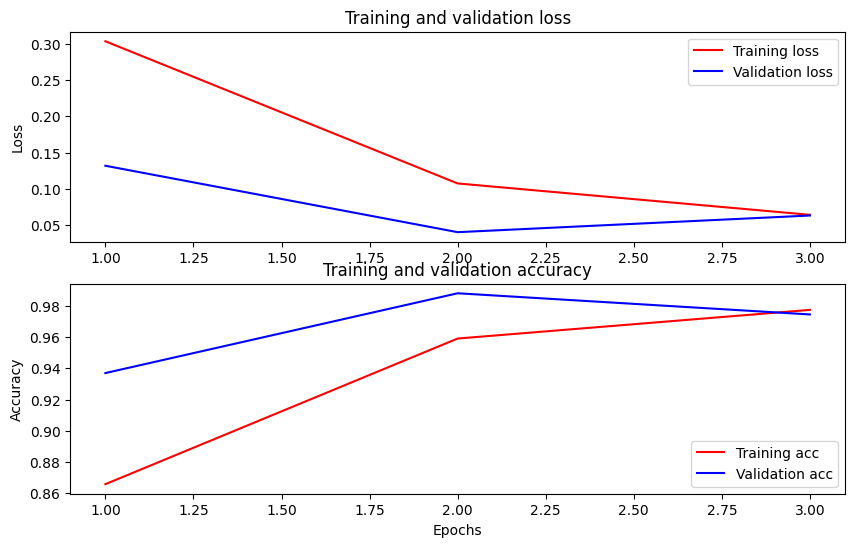

In [15]:
import matplotlib.pyplot as plt
history_dict = history.history
print(history_dict.keys())

acc = history_dict['f1_score']
val_acc = history_dict['val_f1_score']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Testing

In [16]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def preprocess_text_with_bert(text):
    tokens = tokenizer.encode_plus(text, max_length=seq_len, truncation=True, padding='max_length', add_special_tokens=True, return_token_type_ids=False, return_tensors='tf')

    return {
        'input_ids': tf.cast(tokens['input_ids'], tf.float64),
        'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)
    }

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
test = pd.read_csv("/kaggle/input/raw-data/raw_data/raw_data/balancedtest.csv", names=['Label', 'Text'])

y_pred = np.zeros(len(test), dtype=int)
for i, text in enumerate(test['Text']):
    probs = model.predict(preprocess_text_with_bert(text))
#     print(probs.shape)
#     print(probs)
#     print(probs[0])
    y_pred[i] = np.argmax(probs[0])

1/1 [==============================] - 0s 64ms/step


In [21]:
np.savetxt('y_pred.txt', y_pred)

In [ ]:
y_pred

In [ ]:
y_pred = np.loadtxt('/kaggle/input/raw-data/y_pred (1).txt')

In [22]:
y_test = test['Label'].values.copy() # subtract 1 to make the labels 0-based
y_test[y_test != 4] = 0
y_test[y_test == 4] = 1 # 1,2,3 -> 0 (unreliable news), 4 -> 1 (reliable news)
# get the f1 score
f1_score_test = f1_score(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)
print(f1_score_test)
print(accuracy)

0.7663967293026182
0.7936666666666666


In [ ]:
import numpy as np # linear algebra
import IPython.display as ipd


beep = np.sin(2*np.pi*400*np.arange(10000*60)/10000)
ipd.Audio(beep, rate=10000, autoplay=True)

In [ ]:
test = pd.read_excel("/kaggle/input/raw-data/raw_data/raw_data/test.xlsx").rename({'Satirical =1 Legitimate=0': 'Verdict', 'Full Text ': 'Text'}, axis=1) #raw dataframe
y_pred_test = np.zeros(len(test), dtype=int)
for i, text in enumerate(test['Text']):
    probs = model.predict(preprocess_text_with_bert(text))
#     print(probs.shape)
#     print(probs)
#     print(probs[0])
    y_pred_test[i] = np.argmax(probs[0])
    
y_pred_test[y_pred_test == 1] = 2
y_pred_test[y_pred_test == 0] = 1
y_pred_test[y_pred_test == 2] = 0

In [ ]:
%pip install nltk
%pip install afinn

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, precision_score, confusion_matrix
from afinn import Afinn
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('wordnet')

test = pd.read_excel("/kaggle/input/raw-data/raw_data/raw_data/test.xlsx").rename({'Satirical =1 Legitimate=0': 'Verdict', 'Full Text ': 'Text'}, axis=1) #raw dataframe
y_actual = test['Verdict']
# y_pred_test = y_pred_test  # add your model's results when predicting on test.xlsx

def get_superlatives(text):
    superlatives = []
    # Tokenize text into words
    words = word_tokenize(text)
    # Tag words with part-of-speech (POS)
    tagged_words = pos_tag(words)
    # Filter words tagged as superlatives
    for word, pos in tagged_words:
        if pos == 'JJS' or word.endswith('est') or word.startswith('most'):
            superlatives.append(word)
    return superlatives

print("Test F1 score is:", f1_score(y_actual, y_pred_test))
print("Accuracy:", accuracy_score(y_actual, y_pred_test))
print("Precision:", precision_score(y_actual, y_pred_test))
print("Confusion Matrix:")
print(confusion_matrix(y_actual, y_pred_test))

# Per y output type
# print ('Per y label-----')
# for i in range(1, 5):
#     y_cat_actual = y_actual_4outputs[y_actual_4outputs == i].apply(lambda x: 1 if x == 4 else 0) 
#     y_cat_pred = y_pred_test[y_actual_4outputs == i]
#     print("Accuracy:", accuracy_score(y_cat_actual, y_cat_pred))
#     print("Precision:", precision_score(y_cat_actual, y_cat_pred))
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_cat_actual, y_cat_pred))

print()
print('By chracter lengths-----')
text_lengths = test['Text'].apply(lambda entry: len(entry.strip()))
min_length, max_length = min(text_lengths), max(text_lengths)
Q1, Q2, Q3 = np.percentile(text_lengths, 25), np.percentile(text_lengths, 50), np.percentile(text_lengths, 75)
text_char_limits = [min_length, Q1, Q2, Q3, max_length]
for i in range(4):
    y_cat_actual = y_actual[(text_lengths >= text_char_limits[i]) & ((text_lengths <= text_char_limits[i+1]))]
    y_cat_pred = y_pred_test[(text_lengths >= text_char_limits[i]) & ((text_lengths <= text_char_limits[i+1]))]
    print(f'F1 score for {i+1}th quartile: {f1_score(y_cat_actual, y_cat_pred)}')
    print(f'Accuracy for {i+1}th quartile: {accuracy_score(y_cat_actual, y_cat_pred)}')
    print(f'Precision for {i+1}th quartile: {precision_score(y_cat_actual, y_cat_pred)}')


print()
print('By domain')
domains = test['Domain'].unique()
for domain in domains:
    y_cat_actual = y_actual[test['Domain'] == domain]
    y_cat_pred = y_pred_test[test['Domain'] == domain]
    print(f'Entries in {domain}: {len(y_cat_actual)}')
    print(f'F1 score for {domain}: {f1_score(y_cat_actual, y_cat_pred)}')
    print(f'Accuracy for {domain}: {accuracy_score(y_cat_actual, y_cat_pred)}')
    print(f'Precision for {domain}: {precision_score(y_cat_actual, y_cat_pred)}')

print()
print('By Subtopic')
subtopics = test['Subtopic'].unique()
for subtopic in subtopics:
    y_cat_actual = y_actual[test['Subtopic'] == subtopic]
    y_cat_pred = y_pred_test[test['Subtopic'] == subtopic]
    print(f'Entries in {subtopic}: {len(y_cat_actual)}')
    print(f'F1 score for {subtopic}: {f1_score(y_cat_actual, y_cat_pred)}')
    print(f'Accuracy for {subtopic}: {accuracy_score(y_cat_actual, y_cat_pred)}')
    print(f'Precision for {subtopic}: {precision_score(y_cat_actual, y_cat_pred)}')

print()
print('By superlatives per sentence')
superlatives_per_length = test['Text'].apply(lambda entry: len(get_superlatives(entry))/len(entry.strip()))
print(superlatives_per_length)
min_length, max_length = min(superlatives_per_length), max(superlatives_per_length)
Q1, Q2, Q3 = np.percentile(superlatives_per_length, 25), np.percentile(superlatives_per_length, 50), np.percentile(superlatives_per_length, 75)
superlative_limits = [min_length, Q1, Q2, Q3, max_length]
for i in range(4):
    y_cat_actual = y_actual[(superlatives_per_length >= superlative_limits[i]) & ((superlatives_per_length <= superlative_limits[i+1]))]
    y_cat_pred = y_pred_test[(superlatives_per_length >= superlative_limits[i]) & ((superlatives_per_length <= superlative_limits[i+1]))]
    print(f'F1 score for {i+1}th quartile: {f1_score(y_cat_actual, y_cat_pred)}')
    print(f'Accuracy for {i+1}th quartile: {accuracy_score(y_cat_actual, y_cat_pred)}')
    print(f'Precision for {i+1}th quartile: {precision_score(y_cat_actual, y_cat_pred)}')

print()
print('By sentiment analysis (+ve = happy, -ve = sad)')
afn = Afinn()
sentiment_scores = test['Text'].apply(afn.score).apply(lambda s: 1 if s > 3 else -1 if s < -3 else 0)
all_scores = sentiment_scores.unique()
for score in all_scores:
    y_cat_actual = y_actual[sentiment_scores == score]
    y_cat_pred = y_pred_test[sentiment_scores == score]
    print(f'Entries for score {score}: {len(y_cat_actual)}')
    print(f'F1 score for score {score}: {f1_score(y_cat_actual, y_cat_pred)}')
    print(f'Accuracy for score {score}: {accuracy_score(y_cat_actual, y_cat_pred)}')
    print(f'Precision for score {score}: {precision_score(y_cat_actual, y_cat_pred)}')

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Test F1 score is: 0.7511520737327189
Accuracy: 0.7
Precision: 0.6417322834645669
Confusion Matrix:
[[ 89  91]
 [ 17 163]]

By chracter lengths-----
F1 score for 1th quartile: 0.9367088607594937
Accuracy for 1th quartile: 0.8888888888888888
Precision for 1th quartile: 0.9135802469135802
F1 score for 2th quartile: 0.8905109489051095
Accuracy for 2th quartile: 0.8333333333333334
Precision for 2th quartile: 0.9104477611940298
F1 score for 3th quartile: 0.6478873239436619
Accuracy for 3th quartile: 0.7222222222222222
Precision for 3th quartile: 0.5111111111111111
F1 score for 4th quartile: 0.14705882352941174
Accuracy for 4th quartile: 0.35555555555555557
Precision for 4th quartile: 0.08196721311475409

By domain
Entries in Politics/Civics: 60
F1 score for Politics/Civics: 0.7499999999999999
Accuracy for Politics/Civics: 0.6666666666666666
Precision for Politics/Civics: 0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/opt/conda/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: Unde

0      0.000632
1      0.000143
2      0.000363
3      0.000649
4      0.000690
         ...   
355    0.000818
356    0.000000
357    0.000371
358    0.000000
359    0.002523
Name: Text, Length: 360, dtype: float64
F1 score for 1th quartile: 0.8795180722891566
Accuracy for 1th quartile: 0.8148148148148148
Precision for 1th quartile: 0.8588235294117647
F1 score for 2th quartile: 0.7837837837837839
Accuracy for 2th quartile: 0.7333333333333333
Precision for 2th quartile: 0.7073170731707317
F1 score for 3th quartile: 0.6902654867256637
Accuracy for 3th quartile: 0.6111111111111112
Precision for 3th quartile: 0.5571428571428572
F1 score for 4th quartile: 0.7474747474747474
Accuracy for 4th quartile: 0.7222222222222222
Precision for 4th quartile: 0.6065573770491803

By sentiment analysis (+ve = happy, -ve = sad)
Entries for score -1: 145
F1 score for score -1: 0.7528089887640449
Accuracy for score -1: 0.696551724137931
Precision for score -1: 0.6442307692307693
Entries for score 1: 156
F1 

References: <br>
James Briggs: https://www.youtube.com/watch?v=pjtnkCGElcE <br>
Tensor Flow Documentation: https://www.tensorflow.org/text/tutorials/classify_text_with_bert <br>
Balancing datasets: https://medium.com/@tam.tamanna18/handling-imbalanced-datasets-in-python-methods-and-procedures-7376f99794de